In [1]:
import pandas as pd
import geopandas as gpd
import folium
import branca
import datetime
from matplotlib import colors, colormaps
import matplotlib.pyplot as plt
from ipywidgets import widgets, Dropdown, RadioButtons, Output, VBox, HBox
from IPython.display import display, clear_output

<h1>Carregando shapefiles (.shp) referentes às arestas, zonas e distritos</h1>

In [2]:
df = pd.read_csv('csvs/2024-01.csv')
dfo = pd.read_csv('csvs-hex/2024-01o.csv')
dfd = pd.read_csv('csvs-hex/2024-01d.csv')

hexs = gpd.read_file('hexs/base_hexs.shp')

edges = gpd.read_file('edges/base_edges.shp')
edges.crs = 'epsg:4326'

zonas_od = gpd.read_file('OD-2017/Mapas-OD2017/Shape-OD2017/Zonas_2017_region.shp')

zonas_sp = zonas_od[zonas_od['NumeroMuni'] == 36]

# distritos = gpd.read_file('GeoSampa/SIRGAS_SHP_distrito/SIRGAS_SHP_distrito/SIRGAS_SHP_distrito.shp')
# subprefeituras = gpd.read_file('GeoSampa/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp')
distritos = gpd.read_file('edited shapefiles/edited_distritos.shp')
subprefeituras = gpd.read_file('edited shapefiles/edited_subprefeituras.shp')
distritos.set_crs(epsg=31983, inplace=True)
subprefeituras.set_crs(epsg=31983, inplace=True)

if edges.crs != zonas_sp.crs:
    zonas_sp = zonas_sp.to_crs(edges.crs)
if edges.crs != distritos.crs:
    distritos = distritos.to_crs(edges.crs)
if edges.crs != subprefeituras.crs:
    subprefeituras = subprefeituras.to_crs(edges.crs)

In [3]:
df['total_leisure_trip_count'] = df['forward_leisure_trip_count'] + df['reverse_leisure_trip_count']
df['total_commute_trip_count'] = df['forward_commute_trip_count'] + df['reverse_commute_trip_count']
df['18-34'] = df['forward_18_34_people_count'] + df['reverse_18_34_people_count']
df['35-54'] = df['forward_35_54_people_count'] + df['reverse_35_54_people_count']
df['55-64'] = df['forward_55_64_people_count'] + df['reverse_55_64_people_count']
df['65+'] = df['forward_65_plus_people_count'] + df['reverse_65_plus_people_count']
df['Masculino'] = df['forward_male_people_count'] + df['reverse_male_people_count']
df['Feminino'] = df['forward_female_people_count'] + df['reverse_female_people_count']
df['Não Especificado'] = df['forward_unspecified_people_count'] + df['reverse_unspecified_people_count']
    
df = df.drop(columns=['forward_leisure_trip_count', 'reverse_leisure_trip_count', 
                                'forward_commute_trip_count', 'reverse_commute_trip_count',
                                'forward_18_34_people_count', 'reverse_18_34_people_count',
                                'forward_35_54_people_count', 'reverse_35_54_people_count',
                                'forward_55_64_people_count', 'reverse_55_64_people_count',
                                'forward_65_plus_people_count', 'reverse_65_plus_people_count',
                                'forward_male_people_count', 'reverse_male_people_count',
                                'forward_female_people_count', 'reverse_female_people_count',
                                'forward_unspecified_people_count', 'reverse_unspecified_people_count'])


<h2>Radio Buttons e Dropdowns</h2>

In [4]:
granularidade = widgets.RadioButtons(
    options=['Geral', 'Zonas', 'Distritos', 'Subprefeituras'],
    value='Geral',
    description='Granularidade:',
)

granularidade_od = widgets.RadioButtons(
    options=['Geral', 'Zonas', 'Distritos', 'Subprefeituras'],
    value='Geral',
    description='Granularidade:',
)

idade = widgets.RadioButtons(
    options=['Qualquer', '18-34', '35-54', '55-64', '65+'],
    value='Qualquer',
    description='Idade:',
)

genero = widgets.RadioButtons(
    options=['Qualquer', 'Feminino', 'Masculino', 'Não especificado'],
    value='Qualquer',
    description='Gênero:',
)

sorted_zonas = zonas_sp.sort_values(by='NomeZona')
zone_dropdown = Dropdown(
    options=[('Selecione uma zona', None)] + 
            [(f"{row['NomeZona']}", row['NumeroZona']) for index, row in sorted_zonas.iterrows()],
    value=None,
    description='Zona:',
)

zone_dropdown_od = Dropdown(
    options=[('Selecione uma zona', None)] + 
            [(f"{row['NomeZona']}", row['NumeroZona']) for index, row in sorted_zonas.iterrows()],
    value=None,
    description='Zona:',
)

distritos_dropdown = Dropdown(
    options=[('Selecione um distrito', None)] + 
            [(f"{row['ds_nome']}", row['ds_codigo']) for index, row in distritos.iterrows()],
    value=None,
    description='Distrito:',
)

distritos_dropdown_od = Dropdown(
    options=[('Selecione um distrito', None)] + 
            [(f"{row['ds_nome']}", row['ds_codigo']) for index, row in distritos.iterrows()],
    value=None,
    description='Distrito:',
)

subprefeituras_dropdown = Dropdown(
    options=[('Selecione uma subprefeitura', None)] + 
            [(f"{row['sp_nome']}", row['sp_codigo']) for index, row in subprefeituras.iterrows()],
    value=None,
    description='Subprefeituras:',
)

subprefeituras_dropdown_od = Dropdown(
    options=[('Selecione uma subprefeitura', None)] + 
            [(f"{row['sp_nome']}", row['sp_codigo']) for index, row in subprefeituras.iterrows()],
    value=None,
    description='Subprefeituras:',
)

state = {'granularidade': granularidade.value, 'idade': idade.value, 'genero': genero.value, 'granularidade_od': granularidade_od.value}

<h2>Modelos mapas por limite administrativo</h2>

In [5]:
# Mapa padrão - distritos
m_distritos = folium.Map(location=[-23.5789, -46.6388], tiles="CartoDB Positron", zoom_start=11)
folium.GeoJson(
    distritos,
    name='Distritos',
    style_function=lambda feature: {
        'weight': 2,
        'color': 'black',
        'fillOpacity': 0.1
    }
).add_to(m_distritos)
folium.LayerControl().add_to(m_distritos)

# Mapa padrão - zonas
m_zonas = folium.Map(location=[-23.5789, -46.6388], tiles="CartoDB Positron", zoom_start=11)
folium.GeoJson(
    zonas_sp,
    name='Zonas',
    style_function=lambda feature: {
        'weight': 2,
        'color': 'black',
        'fillOpacity': 0.1
    }
).add_to(m_zonas)
folium.LayerControl().add_to(m_zonas)

# Mapa padrão - subprefeituras
m_subprefeituras = folium.Map(location=[-23.5789, -46.6388], tiles="CartoDB Positron", zoom_start=11)
folium.GeoJson(
    subprefeituras,
    name='Subprefeituras',
    style_function=lambda feature: {
        'weight': 2,
        'color': 'black',
        'fillOpacity': 0.1
    }
).add_to(m_subprefeituras)
folium.LayerControl().add_to(m_subprefeituras)

<h2>Zonas OD / Distritos / Subprefeituras</h2>

In [6]:
# Outputs
map_output = Output()
table_output = Output()
dropdown_output = Output()
debug_output = Output()

display(HBox([granularidade, idade, genero]), dropdown_output, VBox([map_output, table_output, debug_output]))

def get_color(grouped, uid, min_val, max_val, col, count):
    if uid not in grouped[col].values:
        norm = colors.Normalize(vmin=min_val, vmax=max_val)
        color_value = norm(min_val)
        return colors.to_hex(cmap(color_value))
    
    total_trips = grouped[grouped[col] == uid][count].values[0]
    norm = colors.Normalize(vmin=min_val, vmax=max_val)
    
    color_value = norm(total_trips)
    return colors.to_hex(cmap(color_value))

# Normalização de valores das escalas
def get_normalization_values(grouped_edges):
    min_val = grouped_edges['total_trip_count'].min()
    max_val = grouped_edges['total_trip_count'].max()
    return min_val, max_val

# Mudança no mapa por granularidade
def update_map(granularidade):
    with map_output:
        map_output.clear_output(wait=True)
        
        if granularidade == "Geral":
            with dropdown_output:
                dropdown_output.clear_output(wait=True)
            display(m_distritos)
            
        elif granularidade == 'Zonas':
            with dropdown_output:
                dropdown_output.clear_output(wait=True)
                display(zone_dropdown)
            display(m_zonas)

        elif granularidade == 'Distritos':
            with dropdown_output:
                dropdown_output.clear_output(wait=True)
                display(distritos_dropdown)
            display(m_distritos)
            
        elif granularidade == 'Subprefeituras':
            with dropdown_output:
                dropdown_output.clear_output(wait=True)
                display(subprefeituras_dropdown)
            display(m_subprefeituras)

# Mudança de zona/distrito/subprefeitura a partir da seleção do usuário
def update_loc(gran, age, gender):
    loc_id = gran
        
    if loc_id is None:
        return

    selected_loc_map = folium.Map(location=[-23.5789, -46.6388], tiles="CartoDB Positron", zoom_start=11)
    
    if granularidade.value == "Zonas":
        full_map = zonas_sp
        grouped_edges = grouped_edges_in_zones
        sufix = 'da Zona'
        selected_loc = zonas_sp[zonas_sp["NumeroZona"] == loc_id]
        name = selected_loc['NomeZona'].iloc[0]
        table_data = trips_per_zone[trips_per_zone['NumeroZona'] == loc_id].reset_index(drop=True)
        table_data = table_data.rename(columns={'NomeZona': 'Nome da Zona', 
                                                'total_trip_count': 'Total de viagens'})
        
    elif granularidade.value == "Distritos":
        full_map = distritos
        grouped_edges = grouped_edges_in_districts
        sufix = 'do Distrito'
        selected_loc = distritos[distritos["ds_codigo"] == loc_id]
        name = selected_loc['ds_nome'].iloc[0]
        table_data = trips_per_district[trips_per_district['ds_nome'] == name].reset_index(drop=True)
        table_data = table_data.rename(columns={'ds_nome': 'Nome do distrito', 
                                                'total_trip_count': 'Total de viagens'})
        
    elif granularidade.value == "Subprefeituras":
        full_map = subprefeituras
        grouped_edges = grouped_edges_in_subprefeituras
        sufix = 'da Subprefeitura'
        selected_loc = subprefeituras[subprefeituras["sp_codigo"] == loc_id]
        name = selected_loc['sp_nome'].iloc[0]
        table_data = trips_per_subprefeituras[trips_per_subprefeituras['sp_nome'] == name].reset_index(drop=True)
        table_data = table_data.rename(columns={'sp_nome': 'Nome da subprefeitura', 
                                                'total_trip_count': 'Total de viagens'})

    # with debug_output:
    #     debug_output.clear_output(wait=True)  
    #     print(f"age: {age}")
    #     print(f"loc-id: {loc_id}")
    #     print(f"gender: {gender}")

    if age is not None and age != "Qualquer":
        table_data = table_data[[col for col in table_data.columns if col in ['Nome da Zona', 'Nome do distrito', 'Nome da subprefeitura', 'Total de viagens', age]]]

    if selected_loc.empty:
        with debug_output:
            print("No matching data found for the selected loc_id.")
        return

    filtered_edges = gpd.overlay(edges, selected_loc, how="intersection")
    selected_edges = grouped_edges[grouped_edges['edgeUID'].isin(filtered_edges['edgeUID'])]
    min_val, max_val = selected_edges['total_trip_count'].min(), selected_edges['total_trip_count'].max()

    # realça a zona/distrito/subprefeitura escolhida
    folium.GeoJson(
        selected_loc,
        style_function=lambda feature: {
            'weight': 0,
            'color': 'black',
            'fillOpacity': 0.1
        }
    ).add_to(selected_loc_map)

    # adiciona os demais zona/distrito/subprefeitura
    # folium.GeoJson(
    #     full_map,
    #     style_function=lambda feature: {
    #         'weight': 2,
    #         'color': color,
    #         'fillOpacity': 0
    #     }
    # ).add_to(selected_loc_map)

    with debug_output:
         debug_output.clear_output(wait=True)  
         print('here')

    # adiciona os edges correspondente a zona/distrito/subprefeitura escolhida
    folium.GeoJson(
        filtered_edges,
        style_function=lambda feature: {
            'weight': 2,
            'color': get_color(selected_edges, feature['properties']['edgeUID'], min_val, max_val, 'edgeUID', 'total_trip_count')
        },
    ).add_to(selected_loc_map)

    # Limites geográficos (bounds) zona/distrito/subprefeitura para focar visualização (zoom)
    bounds = selected_loc.geometry.total_bounds
    sw = [bounds[1], bounds[0]]
    ne = [bounds[3], bounds[2]]
    selected_loc_map.fit_bounds([sw, ne])
    folium.LayerControl().add_to(selected_loc_map)

    with map_output:
        map_output.clear_output(wait=True)
        display(selected_loc_map)

    styled_table = table_data.style \
        .hide(axis='index') \
        .set_table_styles({
            f'Nome {sufix}': [{'selector': 'td, th', 'props': 'width: 200px; text-align: center;'}],
            'Total de viagens': [{'selector': 'td, th', 'props': 'width: 100px; text-align: center;'}]
        }) \
        .set_properties(**{'text-align': 'center', 'padding': '10px'}) \
        .format(thousands=".")

    with table_output:
        table_output.clear_output(wait=True)
        display(styled_table)

# ações com mudança dos Radio Butttons
def on_value_change(change):
    if change['owner'] is granularidade:
        state['granularidade'] = change['new']
        update_map(state['granularidade'])
    elif change['owner'] is idade:
        state['idade'] = change['new']
        loc_id = None
        if granularidade.value == 'Zonas':
            loc_id = zone_dropdown.value
        elif granularidade.value == 'Distritos':
            loc_id = distritos_dropdown.value
        elif granularidade.value == 'Subprefeituras':
            loc_id = subprefeituras_dropdown.value
        update_loc(loc_id, state['idade'], state['genero'])
    elif change['owner'] is genero:
        state['genero'] = change['new']
        loc_id = None
        if granularidade.value == 'Zonas':
            loc_id = zone_dropdown.value
        elif granularidade.value == 'Distritos':
            loc_id = distritos_dropdown.value
        elif granularidade.value == 'Subprefeituras':
            loc_id = subprefeituras_dropdown.value
        update_loc(loc_id, state['idade'], state['genero'])

def compute_trip_counts(grouped_df):
    trips = grouped_df[['total_trip_count', 'total_leisure_trip_count', 'total_commute_trip_count', '18-34', '35-54', '55-64', '65+']].sum().reset_index()
    
    return trips

# Radio Buttons Observers 
granularidade.observe(on_value_change, names='value')
idade.observe(on_value_change, names='value')
genero.observe(on_value_change, names='value')

# Dropdown Observers
zone_dropdown.observe(lambda change: update_loc(change['new'], state['idade'], state['genero']), names='value')
distritos_dropdown.observe(lambda change: update_loc(change['new'], state['idade'], state['genero']), names='value')
subprefeituras_dropdown.observe(lambda change: update_loc(change['new'], state['idade'], state['genero']), names='value')

update_map(state['granularidade'])

edges_in_zones = gpd.sjoin(edges, zonas_sp, how="inner", predicate="intersects")
df_merged_zones = pd.merge(df, edges_in_zones[['edgeUID', 'NumeroZona', 'NomeZona']], left_on='edge_uid', right_on='edgeUID', how='inner')
grouped_edges_in_zones = df_merged_zones.groupby(['edgeUID', 'NumeroZona', 'NomeZona'])['total_trip_count'].sum().reset_index()
grouped_zones = df_merged_zones.groupby(['NumeroZona', 'NomeZona'])

edges_in_districts = gpd.sjoin(edges, distritos, how="inner", predicate="intersects")
df_merged_districts = pd.merge(df, edges_in_districts[['edgeUID', 'ds_nome', 'ds_codigo']], left_on='edge_uid', right_on='edgeUID', how='inner')
grouped_edges_in_districts = df_merged_districts.groupby(['edgeUID', 'ds_codigo', 'ds_nome'])['total_trip_count'].sum().reset_index()
grouped_districts = df_merged_districts.groupby(['ds_nome'])

edges_in_subprefeituras = gpd.sjoin(edges, subprefeituras, how="inner", predicate="intersects")
df_merged_subprefeituras = pd.merge(df, edges_in_subprefeituras[['edgeUID', 'sp_nome', 'sp_codigo']], left_on='edge_uid', right_on='edgeUID', how='inner')
grouped_edges_in_subprefeituras = df_merged_subprefeituras.groupby(['edgeUID', 'sp_codigo', 'sp_nome'])['total_trip_count'].sum().reset_index()
grouped_subprefeituras = df_merged_subprefeituras.groupby(['sp_nome'])
    
cmap = colormaps.get_cmap('YlOrBr')

trips_per_zone = compute_trip_counts(grouped_zones)
trips_per_district = compute_trip_counts(grouped_districts)
trips_per_subprefeituras = compute_trip_counts(grouped_subprefeituras)

Output()

<h2>Origens e Destinos por limite administrativo</h2>

In [7]:
od_map_output = Output()
od_dropdown_output = Output()
debug2 = Output()

display(granularidade_od, od_dropdown_output, od_map_output, debug2)

def update_map_od(granularidade_od):
    with od_map_output:
        od_map_output.clear_output(wait=True)
        
        if granularidade_od == "Geral":
            with od_dropdown_output:
                od_dropdown_output.clear_output(wait=True)
            display(m_distritos)
            
        elif granularidade_od == 'Zonas':
            with od_dropdown_output:
                od_dropdown_output.clear_output(wait=True)
                display(zone_dropdown_od)
            display(m_zonas)

        elif granularidade_od == 'Distritos':
            with od_dropdown_output:
                od_dropdown_output.clear_output(wait=True)
                display(distritos_dropdown_od)
            display(m_distritos)
            
        elif granularidade_od == 'Subprefeituras':
            with od_dropdown_output:
                od_dropdown_output.clear_output(wait=True)
                display(subprefeituras_dropdown_od)
            display(m_subprefeituras)

def update_hexs(gran):
    loc_id = gran
    if loc_id is None:
        return

    hexs_map = folium.Map(location=[-23.5789, -46.6388], tiles="CartoDB Positron", zoom_start=11)
    
    if granularidade_od.value == "Zonas":
        grouped_hexs = grouped_zones_hex
        selected_loc = zonas_sp[zonas_sp["NumeroZona"] == loc_id]
        
    elif granularidade_od.value == "Distritos":
        grouped_hexs = grouped_distritos_hex
        selected_loc = distritos[distritos["ds_codigo"] == loc_id]
        
    elif granularidade_od.value == "Subprefeituras":
        grouped_hexs = grouped_subprefeituras_hex
        selected_loc = subprefeituras[subprefeituras["sp_codigo"] == loc_id]

    filtered_hexs = gpd.overlay(hexs, selected_loc, how="intersection")
    selected_hexs = grouped_hexs[grouped_hexs['hex_id'].isin(filtered_hexs['hex_id'])]
    min_val, max_val = selected_hexs['count'].min(), selected_hexs['count'].max()

    with debug2:
        debug2.clear_output(wait=True)  
        print(loc_id)

    # realça a zona/distrito/subprefeitura escolhida
    # folium.GeoJson(
    #     selected_loc,
    #     style_function=lambda feature: {
    #         'weight': 0,
    #         'color': 'black',
    #         'fillOpacity': 0.1
    #     }
    # ).add_to(hexs_map)

    folium.GeoJson(
        filtered_hexs,
        style_function=lambda feature: {
            'weight': 0.5,
            'color': 'black',
            'fillColor': get_color(selected_hexs, feature['properties']['hex_id'], min_val, max_val, 'hex_id', 'count'),
            'fillOpacity': 0.3
        }
    ).add_to(hexs_map)

    # Limites geográficos (bounds) zona/distrito/subprefeitura para focar visualização (zoom)
    bounds = selected_loc.geometry.total_bounds
    sw = [bounds[1], bounds[0]]
    ne = [bounds[3], bounds[2]]
    hexs_map.fit_bounds([sw, ne])
    folium.LayerControl().add_to(hexs_map)

    with od_map_output:
        od_map_output.clear_output(wait=True)
        display(hexs_map)

def on_value_change_od(change):
    state['granularidade_od'] = change['new']
    update_map_od(state['granularidade_od'])

granularidade_od.observe(on_value_change_od, names='value')

zone_dropdown_od.observe(lambda change: update_hexs(change['new']), names='value')
distritos_dropdown_od.observe(lambda change: update_hexs(change['new']), names='value')
subprefeituras_dropdown_od.observe(lambda change: update_hexs(change['new']), names='value')

update_map_od(state['granularidade_od'])

hexs_in_zones = gpd.sjoin(hexs, zonas_sp, how="inner", predicate="intersects")
dfo_merged_zones = pd.merge(dfo, hexs_in_zones[['hex_id', 'NumeroZona', 'NomeZona']], left_on='hex_id', right_on='hex_id', how='inner')
grouped_zones_hex = dfo_merged_zones.groupby(['hex_id', 'NumeroZona', 'NomeZona'])['count'].sum().reset_index()

hexs_in_distritos = gpd.sjoin(hexs, distritos, how="inner", predicate="intersects")
dfo_merged_distritos = pd.merge(dfo, hexs_in_distritos[['hex_id', 'ds_codigo', 'ds_nome']], left_on='hex_id', right_on='hex_id', how='inner')
grouped_distritos_hex = dfo_merged_distritos.groupby(['hex_id', 'ds_codigo', 'ds_nome'])['count'].sum().reset_index()

hexs_in_subprefeituras = gpd.sjoin(hexs, subprefeituras, how="inner", predicate="intersects")
dfo_merged_subprefeituras = pd.merge(dfo, hexs_in_subprefeituras[['hex_id', 'sp_codigo', 'sp_nome']], left_on='hex_id', right_on='hex_id', how='inner')
grouped_subprefeituras_hex = dfo_merged_subprefeituras.groupby(['hex_id', 'sp_codigo', 'sp_nome'])['count'].sum().reset_index()


RadioButtons(description='Granularidade:', options=('Geral', 'Zonas', 'Distritos', 'Subprefeituras'), value='G…

Output()

Output()

Output()

In [8]:
print(grouped_edges_in_zones)
print(grouped_zones_hex)
#trips_hex.to_csv('hexxx.csv', index=False)

         edgeUID  NumeroZona              NomeZona  total_trip_count
0      325297019         299              Marsilac                15
1      325297020         299              Marsilac                15
2      325297116         299              Marsilac                 5
3      325297118         299              Marsilac                15
4      325297122         299              Marsilac                15
...          ...         ...                   ...               ...
88612  326502790         207  Jardim das Oliveiras                95
88613  326502792         207  Jardim das Oliveiras                95
88614  326502793         207  Jardim das Oliveiras                80
88615  326502794         207  Jardim das Oliveiras                80
88616  326502796         207  Jardim das Oliveiras                95

[88617 rows x 4 columns]
               hex_id  NumeroZona      NomeZona  count
0     88a8100001fffff         285      Pedreira      0
1     88a8100003fffff         285   

<h2>Quartis</h2>

In [9]:
quartis = widgets.RadioButtons(
    options=['Q1', 'Q2', 'Q3', 'Q4'],
    value='Q1',
    description='Quartil:',
)

quartile_map_output = Output()

display(quartis, quartile_map_output)

trips_per_edge = df.groupby('edge_uid').agg({'total_trip_count': 'sum'}).reset_index()
trips_per_edge['quartile'] = pd.qcut(trips_per_edge['total_trip_count'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
edges_in_quartiles = pd.merge(edges, trips_per_edge[['edge_uid', 'quartile']], left_on='edgeUID', right_on='edge_uid', how='inner')

quartile_colors = {
    'Q1': 'green',
    'Q2': 'blue',
    'Q3': 'orange',
    'Q4': 'red'
}

def update_quartile(change):
    quartiles_map = folium.Map(location=[-23.5789, -46.6388], tiles="CartoDB Positron", zoom_start=11)
    selected_quartile = change['new']
    
    filtered_edges = edges_in_quartiles[edges_in_quartiles['quartile'] == selected_quartile]
    
    for _, row in filtered_edges.iterrows():
        folium.GeoJson(
            row['geometry'],
            style_function=lambda feature, color=quartile_colors[selected_quartile]: {
                'color': color,
                'weight': 2,
                'opacity': 1,
            }
        ).add_to(quartiles_map)

    with quartile_map_output:
        quartile_map_output.clear_output(wait=True)
        display(quartiles_map)
    
quartis.observe(update_quartile, names='value')

update_quartile({'new': quartis.value})

RadioButtons(description='Quartil:', options=('Q1', 'Q2', 'Q3', 'Q4'), value='Q1')

Output()

<h2>Velocidades Médias</h2>

RadioButtons(description='Faixas de velocidade em km/h:', options=('< 10', '10-15', '15-20', '20-25', '25-30',…

Output()

Output()

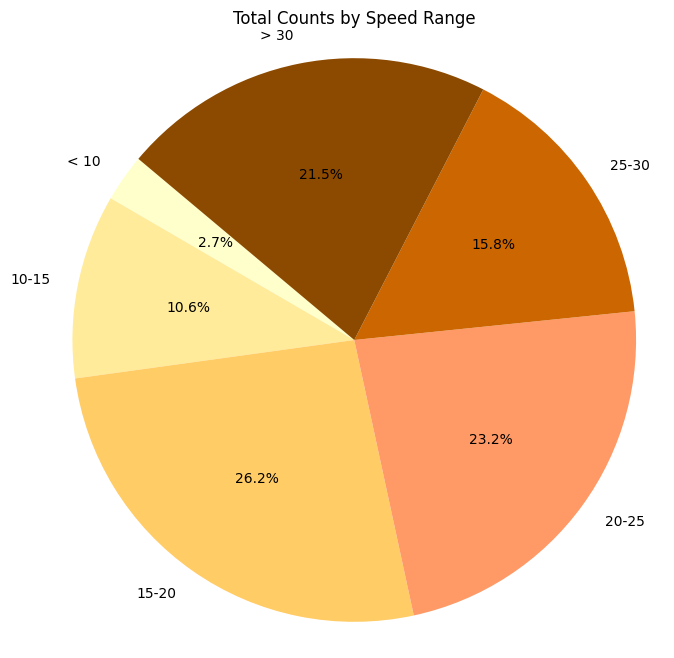

In [14]:
speeds = widgets.RadioButtons(
    options=['< 10', '10-15', '15-20', '20-25', '25-30', '> 30'],
    value='< 10',
    description='Faixas de velocidade em km/h:',
)

average_speed_map_output = Output()
debug3 = Output()
display(speeds, average_speed_map_output, debug3)

def update_speed(change):
    average_speed_map = folium.Map(location=[-23.5789, -46.6388], tiles="CartoDB Positron", zoom_start=11)
    speed_range = change['new']

    if speed_range == '< 10':
        sub_df = grouped_speed[grouped_speed['weighted_average'] < 10]
    elif speed_range == '10-15':
        sub_df = grouped_speed[(grouped_speed['weighted_average'] >= 10) & (grouped_speed['weighted_average'] < 15)]
    elif speed_range == '15-20':
        sub_df = grouped_speed[(grouped_speed['weighted_average'] >= 15) & (grouped_speed['weighted_average'] < 20)]
    elif speed_range == '20-25':
        sub_df = grouped_speed[(grouped_speed['weighted_average'] >= 20) & (grouped_speed['weighted_average'] < 25)]
    elif speed_range == '25-30':
        sub_df = grouped_speed[(grouped_speed['weighted_average'] >= 25) & (grouped_speed['weighted_average'] < 30)]
    elif speed_range == '> 30':
        sub_df = grouped_speed[grouped_speed['weighted_average'] > 30]

    edges_by_speed = edges[edges['edgeUID'].isin(sub_df['edge_uid'])]

    # with debug3:
    #     debug3.clear_output(wait=True)
    #     print(sub_df)
    folium.GeoJson(
        edges_by_speed,
        style_function=lambda feature: {
            'weight': 1,
            'color': 'black',
        }
    ).add_to(average_speed_map)

    with average_speed_map_output:
        average_speed_map_output.clear_output(wait=True)
        display(average_speed_map)

def plot_chart(df):
    df_u10 = grouped_speed[grouped_speed['weighted_average'] < 10]['total'].sum()
    df_10_15 = grouped_speed[(grouped_speed['weighted_average'] >= 10) & (grouped_speed['weighted_average'] < 15)]['total'].sum()
    df_15_20 = grouped_speed[(grouped_speed['weighted_average'] >= 15) & (grouped_speed['weighted_average'] < 20)]['total'].sum()
    df_20_25 = grouped_speed[(grouped_speed['weighted_average'] >= 20) & (grouped_speed['weighted_average'] < 25)]['total'].sum()
    df_25_30 = grouped_speed[(grouped_speed['weighted_average'] >= 25) & (grouped_speed['weighted_average'] < 30)]['total'].sum()
    df_o30 = grouped_speed[grouped_speed['weighted_average'] > 30]['total'].sum()

    totals = [df_u10, df_10_15, df_15_20, df_20_25, df_25_30, df_o30]
    labels = ['< 10', '10-15', '15-20', '20-25', '25-30', '> 30']
    
    # Create the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(totals, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ffffcc', '#ffeb99', '#ffcc66', '#ff9966', '#cc6600', '#8c4a00'])
    plt.title('Total Counts by Speed Range')
    plt.axis('equal')
    plt.show()

def get_average_speed(df):
    forward = df['forward_trip_count'] * df['forward_average_speed_meters_per_second']
    reverse = df['reverse_trip_count'] * df['reverse_average_speed_meters_per_second']
    df['total'] = df['forward_trip_count'] + df['reverse_trip_count']
    df['average_speed'] = (forward + reverse) / df['total']

def group_edges(df):
    grouped = df.groupby('edge_uid').agg(weighted_average=('average_speed', 
                                         lambda x: (x * df.loc[x.index, 'total']).sum() / df.loc[x.index, 'total'].sum()), total=('total', 'sum')).reset_index()
    grouped['weighted_average'] = grouped['weighted_average'] * 3.6 # m/s => km/h

    return grouped
    
speed_df = df[['edge_uid', 'forward_trip_count', 'reverse_trip_count', 
               'forward_average_speed_meters_per_second', 'reverse_average_speed_meters_per_second']].copy()
get_average_speed(speed_df)
grouped_speed = group_edges(speed_df)
plot_chart(grouped_speed)

grouped_speed.to_csv('test.csv', index=False)

speeds.observe(update_speed, names='value')
update_speed({'new': speeds.value})

In [11]:
print(edges.columns)

Index(['edgeUID', 'osmId', 'geometry'], dtype='object')


In [12]:
import datetime
import ipywidgets as widgets

# Create a list of dates from January 2019 to September 2024
start_date = datetime.date(2019, 1, 1)
end_date = datetime.date(2024, 9, 1)

# Generate a list of month start dates
dates = [start_date + datetime.timedelta(days=30 * i) for i in range((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1)]

# Format options for the slider
options = [(i.strftime('%b %Y'), i) for i in dates]

# Create a SelectionRangeSlider widget
slider = widgets.SelectionRangeSlider(
    options=options,
    index=(0, len(options) - 1),  # Set the default range to include all months
    description='Período',
    disabled=False
)

slider.layout.width = '1000px'

# Display the slider
display(slider)

SelectionRangeSlider(description='Período', index=(0, 68), layout=Layout(width='1000px'), options=(('Jan 2019'…